# Basic Examples
This notebook illustrates the basic functions in this repository.

In [1]:
%matplotlib inline
import numpy as np
import sys

import osh5io
import osh5def
import osh5vis
import osh5utils
import matplotlib.pyplot as plt

Fail to import GUI routines. Check your PyQT installation


## Basic IO
The following section show how to write/read hdf5 data with osh5io. 

We first make up heuristic data similar to OSIRIS output format and write it to disk. We then read the file and plot it with osh5vis.

#### Create the data

In [2]:
# The actural data is a numpy array
a = np.arange(30.0).reshape((6, 5))

# Here are the two axes. Don't worry about the details because you will get them when reading from the real simulation data
x = osh5def.DataAxis(10, 15, 5, attrs={'NAME':'x1', 'LONG_NAME':'x_1', 'UNITS':'c / \omega_p'})
y = osh5def.DataAxis(0, 1, 6, attrs={'NAME':'t', 'LONG_NAME':'time', 'UNITS':'1 / \omega_p'})

# More attributes associated with the data/simulation. Again no need to worry about the details.
data_attrs = {'UNITS': osh5def.OSUnits('m_e c \omega_p / e'), 'NAME': 'e1', 'LONG_NAME': 'E_1'}
run_attrs = {'NOTE': 'parameters about this simulation are stored here', 'TIME UNITS': '1/\omega_p'}

# Now "wrap" the numpy array into osh5def.H5Data. Note that the data and the axes are consistent and are in fortran ordering
b = osh5def.H5Data(a, timestamp='123456', data_attrs=data_attrs, run_attrs=run_attrs, axes=[y, x])

#### Write data to disk
Note that without supplying the output filename, write_h5 will use the '*name*' and '*timestamp*' to construct
the filename and write to current directory.

In [3]:
osh5io.write_h5(b)

#### Read the data back and do basic inspection
note that there are more entries in the run_attrs dictionary. They would have got proper values if reading from real simulation data. 

In [4]:
# ./e1-123456.h5 is the data we just write out
c = osh5io.read_h5('./e1-123456.h5')

# print(repr(c))
c

osh5def.H5Data at 0x2b3797249ba8, shape(6, 5),
axis:
  osh5def.DataAxis at 0x2b3797281320: size=6, (min, max)=(0.0, 0.99999999999999989), {'UNITS': osh5def.OSUnits at 0x2b3797281390: ['m_e', 'c', '\\omega_p', 'e', 'n_0']=[0, 0, -1, 0, 0], 'LONG_NAME': 'time', 'NAME': 't'}
  osh5def.DataAxis at 0x2b3797281400: size=5, (min, max)=(10.0, 15.0), {'UNITS': osh5def.OSUnits at 0x2b3797281470: ['m_e', 'c', '\\omega_p', 'e', 'n_0']=[0, 1, -1, 0, 0], 'LONG_NAME': 'x_1', 'NAME': 'x1'}
data_attrs: {'NAME': 'e1', 'UNITS': osh5def.OSUnits at 0x2b3797281198: ['m_e', 'c', '\\omega_p', 'e', 'n_0']=[1, 1, 1, -1, 0], 'LONG_NAME': 'E_1'}
run_attrs:{'DT': array([ 1.]), 'ITER': array([0]), 'MOVE C': array([0]), 'PERIODIC': array([0]), 'TIME': array([ 0.]), 'TYPE': 'grid', 'XMIN': array([ 0.]), 'XMAX': array([ 0.]), 'NOTE': 'parameters about this simulation are stored here', 'TIME UNITS': '1/\\omega_p'}

#### Plot
Since the axes are part of the object, it is enough to supply only the object as the argument to get a nice plot with axis label etc.

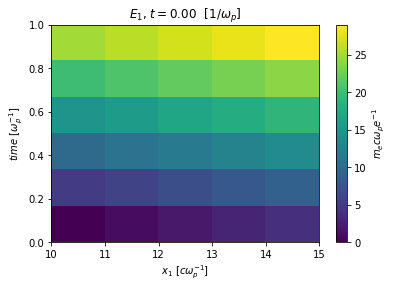

In [5]:
osh5vis.osplot(c)

## Basic functions/operations
The H5Data is a subclass of numpy ndarray, so *theoretically* it supports all functions that take ndarray as input.

In the following cell we plot the square (and the FFT) of the field. Note that the unit of the data (and the axis) will change automatically.

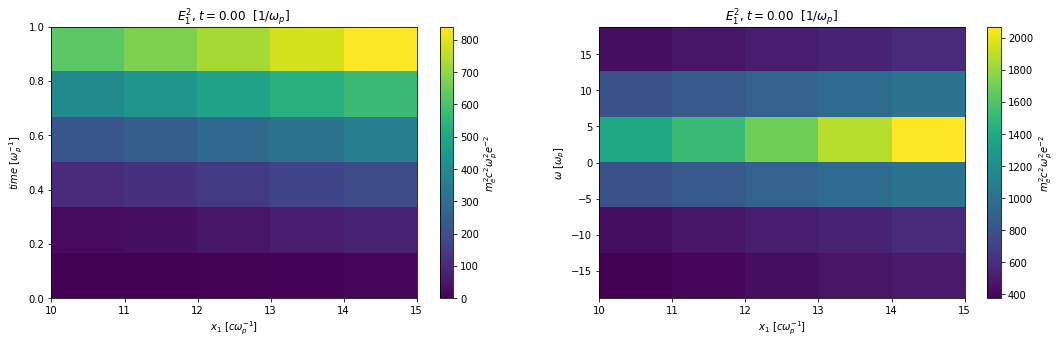

In [6]:
d = c**2
# For now user has to change the name attribute manually. We might automate these kind of basic routines depending on the feedback.
d.data_attrs['LONG_NAME'] += '^2'
plt.figure(figsize=[18,5])
plt.subplot(121)
osh5vis.osplot(d)

# Please use the FFT in osh5utils so that the axes are handled correctly. The FFT interfaces are identical to the numpy ones.
# also note that we can use np.abs directly on our data.
e = np.abs(osh5utils.fft(d, axis=0))
plt.subplot(122)
osh5vis.osplot(e)

## Some unique features
One of the motivations of writing this library is to bundle the metadata and the data. Most importantly, we can manipulate the data without constantly adjusting/keeping track of the axes data. We have seen some of these in the FFT example above. I am going to show a bit more in the following cells.

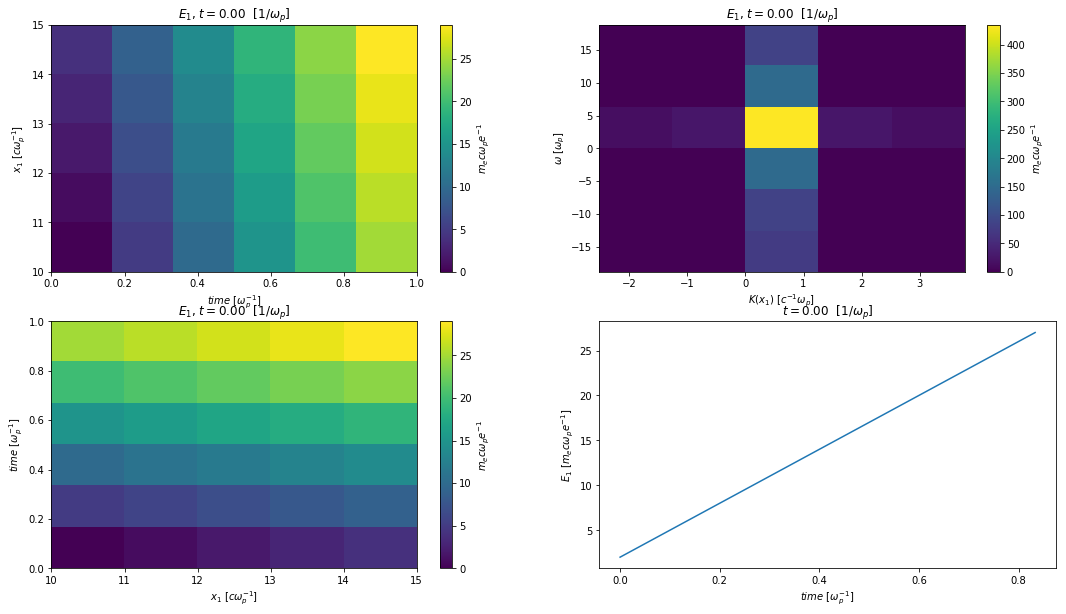

In [7]:
plt.figure(figsize=[18,10])

# ================================ EXAMPLE 1, upper left ==========================================
# if we want to switch the axes of the image, it feels natural to plot transposed 2d array and we can just do that. 
# Note that we can also use np.transpose(c) or c.transpose()
plt.subplot(221)
osh5vis.osplot(c.T)

# ================================ EXAMPLE 2, upper right ==========================================
# Let's plot the FFT again but this time we transform both in time and space
# Note the label and unit of each axis are handled differently. And axes are shifted.
plt.subplot(222)
f = osh5utils.fft2(c)
osh5vis.osplot(np.abs(f))

# ================================ EXAMPLE 3, lower left ==========================================
# Now let's do the inverse FFT on data f in previous example
# Note that the 'x1' axis does not start from 0; this information is preserved after fft/ifft transform pair
plt.subplot(223)
g = np.abs(osh5utils.ifft2(f))
osh5vis.osplot(g)

# ================================ EXAMPLE 4, lower right ==========================================
# slicing/indexing the data will return data with corresponding axes. More on this in next cell
plt.subplot(224)
plt.title('$x_1$ = %1.1f [%s]' % (float(c.axes[1][2]), c.axes[1].attrs['UNITS'].tex()))
osh5vis.osplot(c[:,2])

In order to show more clearly the indexing/slicing feature, we first make a 3D data. Then I will demonstrate what happen to the axes when we use different indexing methods. All numpy ndarray indexing and slicing methods are supported.

Basically we follow the indexing rules of the numpy array: If basic slicing and indexing is used, a view is returned; if advanced indexing is used, the H5Data object will be converted to an ndarray, in which case users are still directly interacting with the actual data, just that the advantage of data-metadata bundling is lost. In any cases, we discourage end users from fiddling with axes data values directly.

In [8]:
# h is the 3D data used for illustration
z = osh5def.DataAxis(0, 1, 7, attrs={'NAME':'p1', 'LONG_NAME':'p_1', 'UNITS':'m_e c'})
h = osh5def.H5Data(np.arange(210.).reshape(7, 6, 5), data_attrs=data_attrs, run_attrs=run_attrs, axes=[z, y, x])

# ===
# The following examples mimic the numpy tutorial for array indexing but here we only concern about the axes
# ===

print('---------------------------- EXAMPLE 1 ---------------------------------')
# x and y axes are not changed
print('the z axis of h is', h.axes[0][:])
print('the z axis of h[1:7:2, :, :] is', h[1:7:2, :, :].axes[0][:])

print('\n---------------------------- EXAMPLE 2 ---------------------------------')
print('the z axis of h[-2:7, :, :] is', h[-2:7, :, :].axes[0][:])

print('\n---------------------------- EXAMPLE 3 ---------------------------------')
# not sure why but you do reverse the order of axes (and data)
print('the z axis of h[-1:3:-1,:,:] is', h[-1:3:-1,:,:].axes[0][:])

print('\n---------------------------- EXAMPLE 4 ---------------------------------')
print('the z axis of h[5:, :, :] is', h[5:, :, :].axes[0][:])

print('\n---------------------------- EXAMPLE 5 ---------------------------------')
# Note that y axis is not there any more
print('the axes of h[:, 2] are')
[print(ax) for ax in h[:,2].axes]

print('\n---------------------------- EXAMPLE 6 ---------------------------------')
# usage of the ellipsis. also note that we can keep the degenerate axis with the same trick as in numpy
print('the axes of h[..., 2:3] are')
[print(ax) for ax in h[..., 2:3].axes]

print('\n---------------------------- EXAMPLE 7 ---------------------------------')
# not sure why but you do add a dummy axis and increase the dimensionality of the data
print('the dimension of h[:,np.newaxis,:,:] is', h[:,np.newaxis,:,:].shape, ', and the axes are')
[print(ax) for ax in h[:,np.newaxis,:,:].axes]

# ---------------
# from now on we demonstrate the advance indexing, in which case the return is an ndarray
print('\n------------------------- advanced indexing -----------------------------')
print('---------------------------- EXAMPLE 8 ---------------------------------')
print('result of h[h<15] is ', type(h[h<15]))
print(h[h<15])


print('\n---------------------------- EXAMPLE 9 ---------------------------------')
print('result of h[[0, 1, 2], [0, 1, 0]] is ', type(h[[0, 1, 2], [0, 1, 0]]))
print(h[[0, 1, 2], [0, 1, 0]])

print('\n---------------------------- EXAMPLE 10 ---------------------------------')
# Although the actrual data is the same as h[1:2, 1:2], the following result in an ndarray instead of H5Data
print('result of h[1:2, [1, 2]] is ', type(h[1:2, [1, 2]]))
print(h[1:2, [1, 2]])

print('\n---------------------------- EXAMPLE 11 ---------------------------------')
# The return of advance indexing is the *actual* data itself, not a copy. Changing it will change the original data
h[:6, [1, 2, 4, 5]] = 0
print('After setting h[:6, [1, 2, 4, 5]] to 0, print the content of h:\n', h.view(np.ndarray))


---------------------------- EXAMPLE 1 ---------------------------------
the z axis of h is [ 0.          0.14285714  0.28571429  0.42857143  0.57142857  0.71428571
  0.85714286]
the z axis of h[1:7:2, :, :] is [ 0.14285714  0.42857143  0.71428571]

---------------------------- EXAMPLE 2 ---------------------------------
the z axis of h[-2:7, :, :] is [ 0.71428571  0.85714286]

---------------------------- EXAMPLE 3 ---------------------------------
the z axis of h[-1:3:-1,:,:] is [ 0.85714286  0.71428571  0.57142857]

---------------------------- EXAMPLE 4 ---------------------------------
the z axis of h[5:, :, :] is [ 0.71428571  0.85714286]

---------------------------- EXAMPLE 5 ---------------------------------
the axes of h[:, 2] are
p1: [0.0, 0.857142857143] m_e c 
x1: [10.0, 14.0] c \omega_p^{-1} 

---------------------------- EXAMPLE 6 ---------------------------------
the axes of h[..., 2:3] are
p1: [0.0, 0.857142857143] m_e c 
t: [0.0, 0.833333333333] \omega_p^{-1} 
x1: [12

## Conclusion
In this notebook we walked through the basic input/output, arithmetic and a few frequently used functions for the H5Data and learned about the indexing/slicing behaviors of H5Data. More functionalities, such as indexing by axes values, can be found in the source files docstrings.